# Explainer notebook

In this notebook I'll explain the steps and thought process behind all my data processing, feature engineering, model creation, validation and optimizations.

All the functions i wrote here were later organized in separate modules, this notebook is an example for explaining only 

The API will be documented separately.


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import shutil
import os
import seaborn as sns
import kagglehub
import xgboost as xgb

import mlflow
import mlflow.xgboost
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

/home/martim/traive/ml_challenge/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Loading and exploring the data

Here is a basic EDA with some plots to understand the relationship between variables. The plots are quite heavy and take some time to render, i suggest to skip running the cells for the EDA

## Preprocessing

In [4]:
def load_raw_data():
    # Download latest version
    path = kagglehub.dataset_download("neuromusic/avocado-prices")

    destination_folder = "./data"
    # Create the destination folder if it doesn't exist
    os.makedirs(destination_folder, exist_ok=True)

    # Move all files from source to destination
    for filename in os.listdir(path):
        source_file = os.path.join(path, filename)
        destination_file = os.path.join(destination_folder, filename)
        shutil.move(source_file, destination_file)

    df = pd.read_csv('data/avocado.csv')
    return df

df = load_raw_data()

In [5]:
df

Unnamed: 0        Date  AveragePrice  Total Volume     4046       4225  \
0               0  2015-12-27          1.33      64236.62  1036.74   54454.85   
1               1  2015-12-20          1.35      54876.98   674.28   44638.81   
2               2  2015-12-13          0.93     118220.22   794.70  109149.67   
3               3  2015-12-06          1.08      78992.15  1132.00   71976.41   
4               4  2015-11-29          1.28      51039.60   941.48   43838.39   
...           ...         ...           ...           ...      ...        ...   
18244           7  2018-02-04          1.63      17074.83  2046.96    1529.20   
18245           8  2018-01-28          1.71      13888.04  1191.70    3431.50   
18246           9  2018-01-21          1.87      13766.76  1191.92    2452.79   
18247          10  2018-01-14          1.93      16205.22  1527.63    2981.04   
18248          11  2018-01-07          1.62      17489.58  2894.77    2356.13   

         4770  Total Bags  Small Bags  Large Bags  XLarge Bags          type  \
0       48.16     8696.87     8603.62       93.25          0.0  conventional   
1       58.33     9505.56     9408.07       97.49          0.0  conventional   
2      130.50     8145.35     8042.21      103.14          0.0  conventional   
3       72.58     5811.16     5677.40      133.76          0.0  conventional   
4       75.78     6183.95     5986.26      197.69          0.0  conventional   
...       ...         ...         ...         ...          ...           ...   
18244    0.00    13498.67    13066.82      431.85          0.0       organic   
18245    0.00     9264.84     8940.04      324.80          0.0       organic   
18246  727.94     9394.11     9351.80       42.31          0.0       organic   
18247  727.01    10969.54    10919.54       50.00          0.0       organic   
18248  224.53    12014.15    11988.14       26.01          0.0       organic   

       year            region  
0      2015            Albany  
1      2015            Albany  
2      2015            Albany  
3      2015            Albany  
4      2015            Albany  
...     ...               ...  
18244  2018  WestTexNewMexico  
18245  2018  WestTexNewMexico  
18246  2018  WestTexNewMexico  
18247  2018  WestTexNewMexico  
18248  2018  WestTexNewMexico  

[18249 rows x 14 columns]

The DF has a "Unnamed: 0" column with repeating indices regarding the weeks of the year for each region and each type of avocado. Since i'll be dealing with the dates later this column will be dropped. 

The date column needs to be a datetime, and the names are not standardized, so i'll write a preprocess function to fix all this details}

In [6]:
def preprocess_raw_data(df):
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date')
    # df = df.set_index('Date')
    df = df.drop(['Unnamed: 0', 'year'], axis=1)
    df.columns = df.columns.str.strip()
    df.columns = df.columns.str.replace(' ', '')
    df.columns = df.columns.str[0].str.upper() + df.columns.str[1:]
    return df

df = preprocess_raw_data(df)

In [7]:
df

Date  AveragePrice  TotalVolume        4046       4225       4770  \
11569 2015-01-04          1.75     27365.89     9307.34    3844.81     615.28   
9593  2015-01-04          1.49     17723.17     1189.35   15628.27       0.00   
10009 2015-01-04          1.68      2896.72      161.68     206.96       0.00   
1819  2015-01-04          1.52     54956.80     3013.04   35456.88    1561.70   
9333  2015-01-04          1.64      1505.12        1.27    1129.50       0.00   
...          ...           ...          ...         ...        ...        ...   
8574  2018-03-25          1.36    908202.13   142681.06  463136.28  174975.75   
9018  2018-03-25          0.70   9010588.32  3999735.71  966589.50   30130.82   
18141 2018-03-25          1.42    163496.70    29253.30    5080.04       0.00   
17673 2018-03-25          1.70    190257.38    29644.09   70982.10       0.00   
8814  2018-03-25          1.34   1774776.77    63905.98  908653.71     843.45   

        TotalBags   SmallBags  LargeBags  XLargeBags          Type  \
11569    13598.46    13061.10     537.36        0.00       organic   
9593       905.55      905.55       0.00        0.00       organic   
10009     2528.08     2528.08       0.00        0.00       organic   
1819     14925.18    11264.80    3660.38        0.00  conventional   
9333       374.35      186.67     187.68        0.00       organic   
...           ...         ...        ...         ...           ...   
8574    127409.04   103579.41   22467.04     1362.59  conventional   
9018   4014132.29  3398569.92  546409.74    69152.63  conventional   
18141   129163.36   109052.26   20111.10        0.00       organic   
17673    89631.19    89424.11     207.08        0.00       organic   
8814    801373.63   774634.09   23833.93     2905.61  conventional   

                   Region  
11569           Southeast  
9593              Chicago  
10009  HarrisburgScranton  
1819           Pittsburgh  
9333                Boise  
...                   ...  
8574              Chicago  
9018         SouthCentral  
18141        SouthCentral  
17673          California  
8814              NewYork  

[18249 rows x 12 columns]

## Exploratory Data Analysis (EDA)

- **Date**: The date of the observation
- **AveragePrice**: The average price of a single avocado
- **type**: Conventional or organic
- **year**: The year
- **Region**: The city or region of the observation
- **Total Volume**: Total number of avocados sold
- **4046**: Total number of avocados with PLU 4046 sold
- **4225**: Total number of avocados with PLU 4225 sold
- **4770**: Total number of avocados with PLU 4770 sold

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18249 entries, 11569 to 8814
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          18249 non-null  datetime64[ns]
 1   AveragePrice  18249 non-null  float64       
 2   TotalVolume   18249 non-null  float64       
 3   4046          18249 non-null  float64       
 4   4225          18249 non-null  float64       
 5   4770          18249 non-null  float64       
 6   TotalBags     18249 non-null  float64       
 7   SmallBags     18249 non-null  float64       
 8   LargeBags     18249 non-null  float64       
 9   XLargeBags    18249 non-null  float64       
 10  Type          18249 non-null  object        
 11  Region        18249 non-null  object        
dtypes: datetime64[ns](1), float64(9), object(2)
memory usage: 1.8+ MB


In [9]:
df['Region'].unique()

array(['Southeast', 'Chicago', 'HarrisburgScranton', 'Pittsburgh',
       'Boise', 'WestTexNewMexico', 'LosAngeles', 'LasVegas', 'Atlanta',
       'DallasFtWorth', 'MiamiFtLauderdale', 'Plains', 'StLouis',
       'Syracuse', 'Midsouth', 'Sacramento', 'Boston', 'Charlotte',
       'Spokane', 'Albany', 'Houston', 'SouthCarolina', 'SanFrancisco',
       'TotalUS', 'RaleighGreensboro', 'BuffaloRochester',
       'NorthernNewEngland', 'GrandRapids', 'Denver', 'SanDiego',
       'BaltimoreWashington', 'Roanoke', 'RichmondNorfolk', 'Northeast',
       'SouthCentral', 'GreatLakes', 'Louisville', 'Seattle',
       'CincinnatiDayton', 'NewYork', 'NewOrleansMobile', 'Indianapolis',
       'Jacksonville', 'Columbus', 'Detroit', 'Philadelphia',
       'PhoenixTucson', 'Nashville', 'Portland', 'HartfordSpringfield',
       'Tampa', 'Orlando', 'West', 'California'], dtype=object)

In [10]:
df['Type'].unique()

array(['organic', 'conventional'], dtype=object)

In [11]:
df.describe()

Date  AveragePrice   TotalVolume  \
count                          18249  18249.000000  1.824900e+04   
mean   2016-08-13 23:30:43.498273792      1.405978  8.506440e+05   
min              2015-01-04 00:00:00      0.440000  8.456000e+01   
25%              2015-10-25 00:00:00      1.100000  1.083858e+04   
50%              2016-08-14 00:00:00      1.370000  1.073768e+05   
75%              2017-06-04 00:00:00      1.660000  4.329623e+05   
max              2018-03-25 00:00:00      3.250000  6.250565e+07   
std                              NaN      0.402677  3.453545e+06   

               4046          4225          4770     TotalBags     SmallBags  \
count  1.824900e+04  1.824900e+04  1.824900e+04  1.824900e+04  1.824900e+04   
mean   2.930084e+05  2.951546e+05  2.283974e+04  2.396392e+05  1.821947e+05   
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    8.540700e+02  3.008780e+03  0.000000e+00  5.088640e+03  2.849420e+03   
50%    8.645300e+03  2.906102e+04  1.849900e+02  3.974383e+04  2.636282e+04   
75%    1.110202e+05  1.502069e+05  6.243420e+03  1.107834e+05  8.333767e+04   
max    2.274362e+07  2.047057e+07  2.546439e+06  1.937313e+07  1.338459e+07   
std    1.264989e+06  1.204120e+06  1.074641e+05  9.862424e+05  7.461785e+05   

          LargeBags     XLargeBags  
count  1.824900e+04   18249.000000  
mean   5.433809e+04    3106.426507  
min    0.000000e+00       0.000000  
25%    1.274700e+02       0.000000  
50%    2.647710e+03       0.000000  
75%    2.202925e+04     132.500000  
max    5.719097e+06  551693.650000  
std    2.439660e+05   17692.894652

In [12]:
df.isnull().sum()

Date            0
AveragePrice    0
TotalVolume     0
4046            0
4225            0
4770            0
TotalBags       0
SmallBags       0
LargeBags       0
XLargeBags      0
Type            0
Region          0
dtype: int64

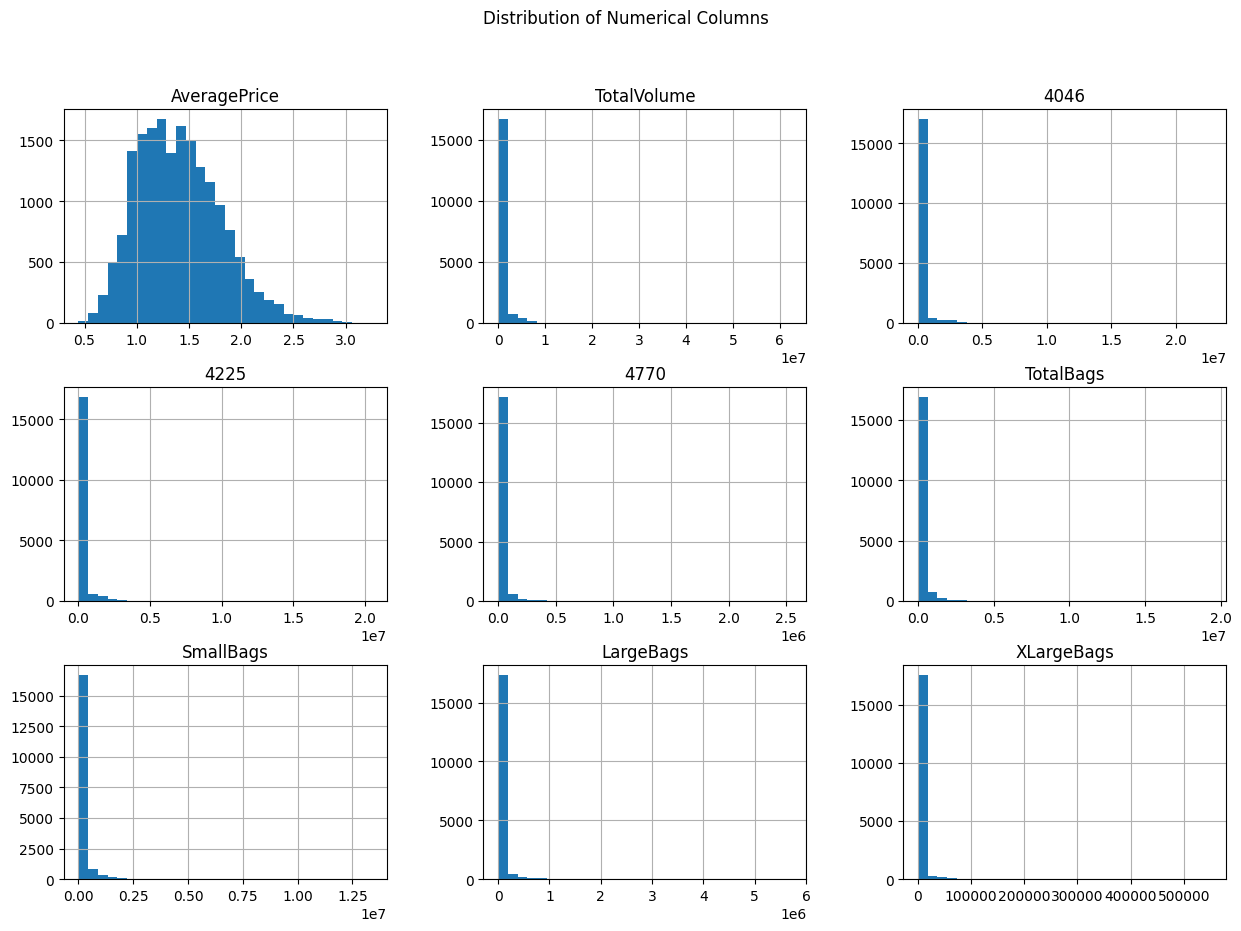

In [114]:
# Visualize the distribution of numerical columns
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns
df[numerical_columns].hist(figsize=(15, 10), bins=30)
plt.suptitle('Distribution of Numerical Columns')
plt.show()

In [14]:
df.head()

Date  AveragePrice  TotalVolume     4046      4225     4770  \
11569 2015-01-04          1.75     27365.89  9307.34   3844.81   615.28   
9593  2015-01-04          1.49     17723.17  1189.35  15628.27     0.00   
10009 2015-01-04          1.68      2896.72   161.68    206.96     0.00   
1819  2015-01-04          1.52     54956.80  3013.04  35456.88  1561.70   
9333  2015-01-04          1.64      1505.12     1.27   1129.50     0.00   

       TotalBags  SmallBags  LargeBags  XLargeBags          Type  \
11569   13598.46   13061.10     537.36         0.0       organic   
9593      905.55     905.55       0.00         0.0       organic   
10009    2528.08    2528.08       0.00         0.0       organic   
1819    14925.18   11264.80    3660.38         0.0  conventional   
9333      374.35     186.67     187.68         0.0       organic   

                   Region  
11569           Southeast  
9593              Chicago  
10009  HarrisburgScranton  
1819           Pittsburgh  
9333                Boise

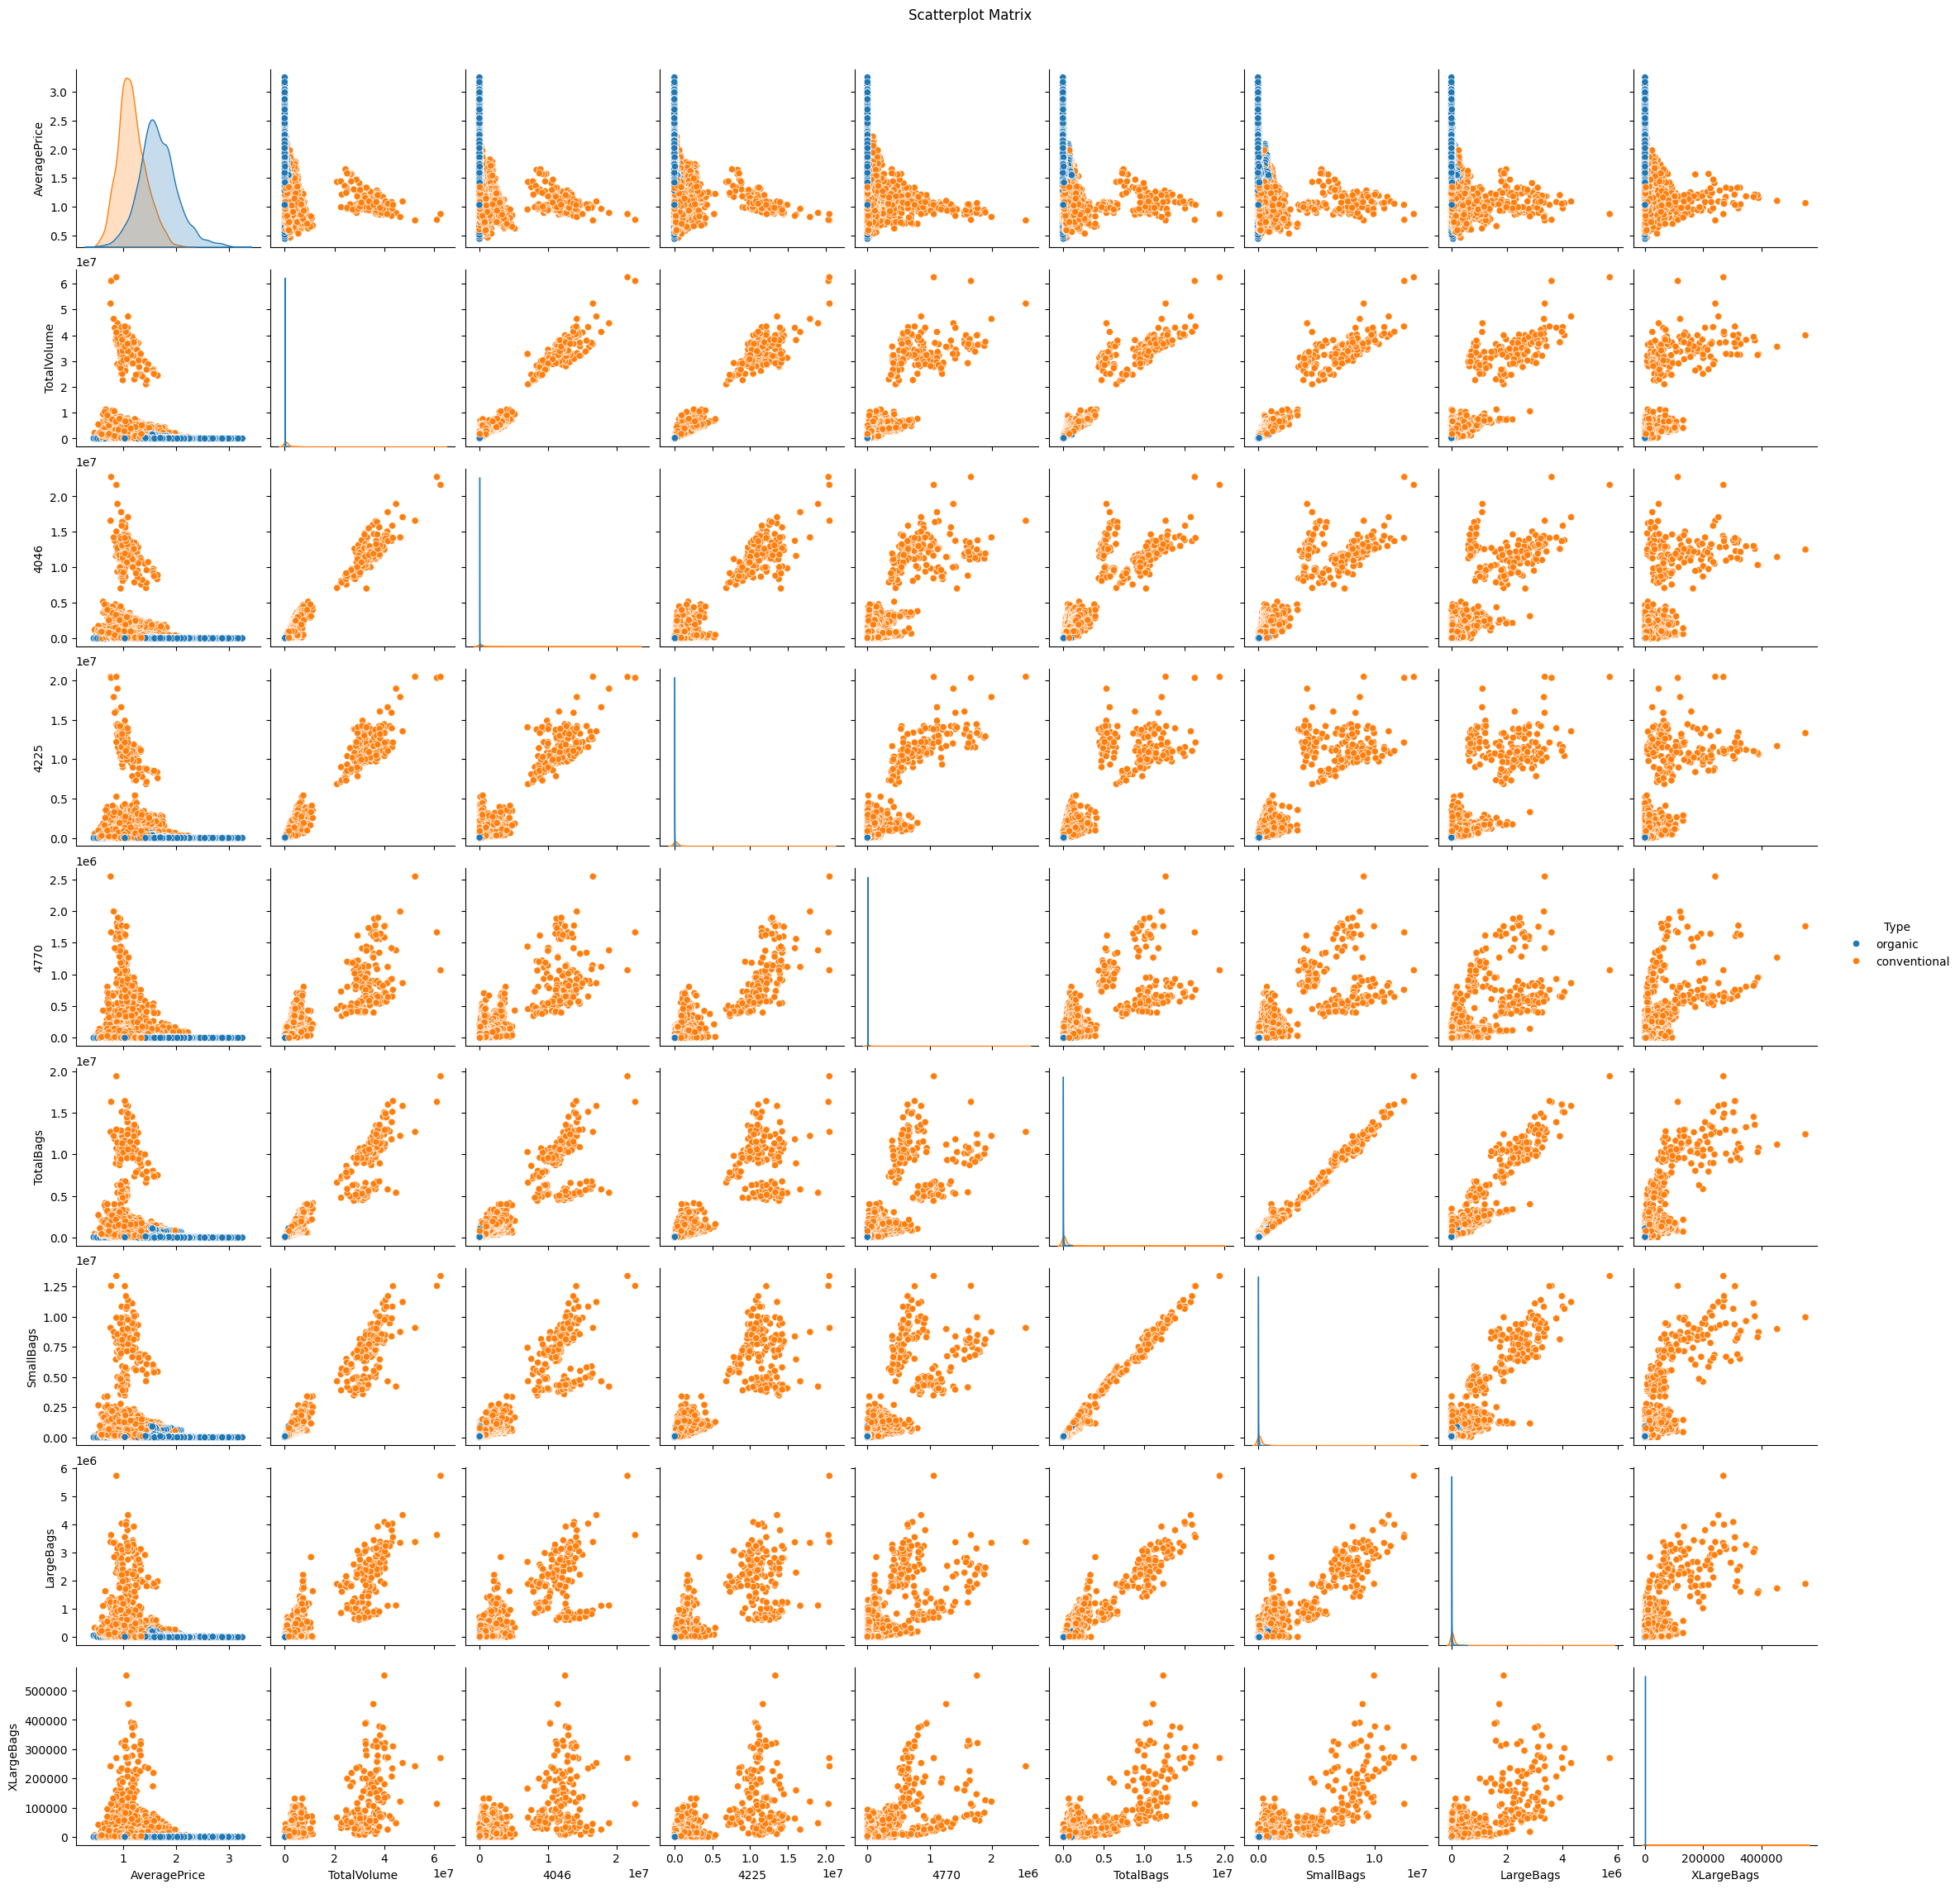

In [115]:
# Plot the scatterplot matrix
sns.pairplot(df, hue='Type')
plt.suptitle('Scatterplot Matrix', y=1.02)
plt.show()

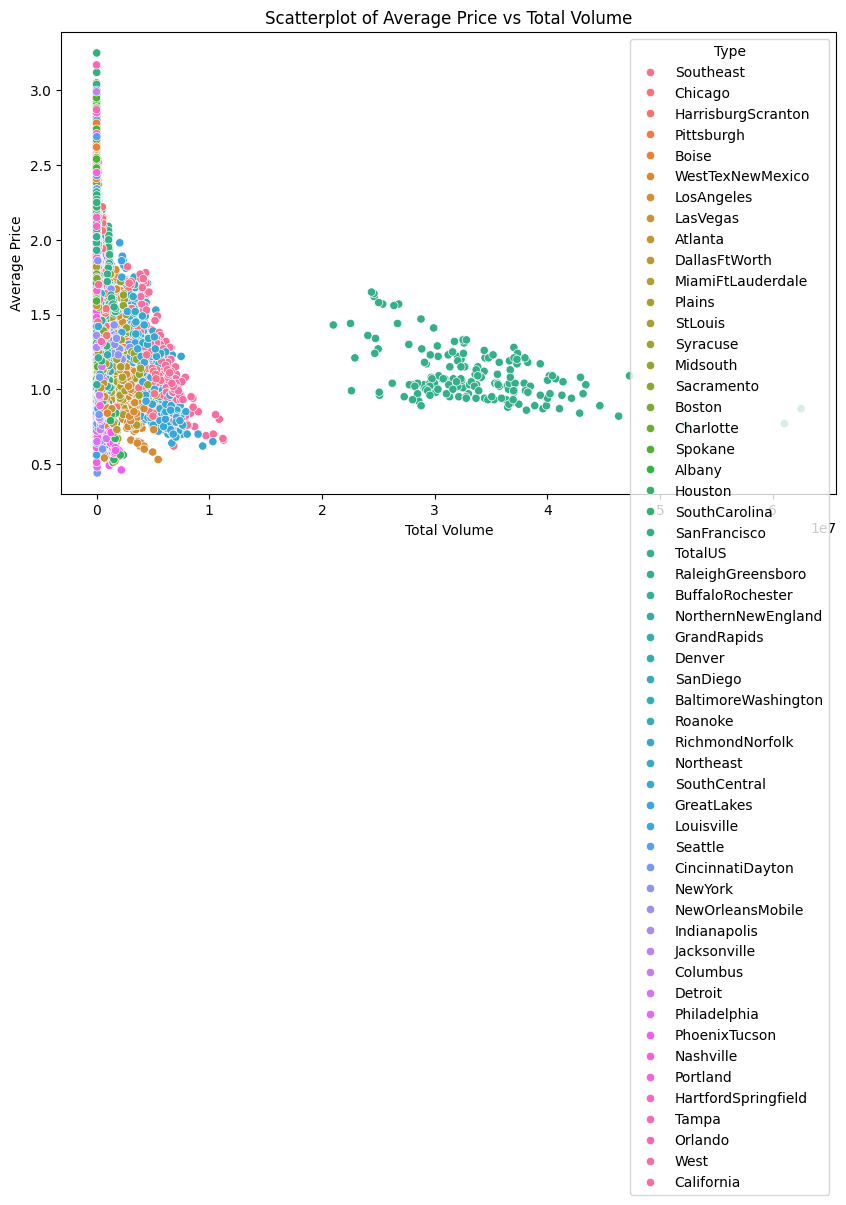

In [116]:
# Plot scatterplot of AveragePrice and Total Volume
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='TotalVolume', y='AveragePrice', hue='Region')
plt.title('Scatterplot of Average Price vs Total Volume')
plt.xlabel('Total Volume')
plt.ylabel('Average Price')
plt.legend(title='Type')
plt.show()

In [117]:
df[df['TotalVolume'] > 2e7]['Region'].unique()

array(['TotalUS'], dtype=object)

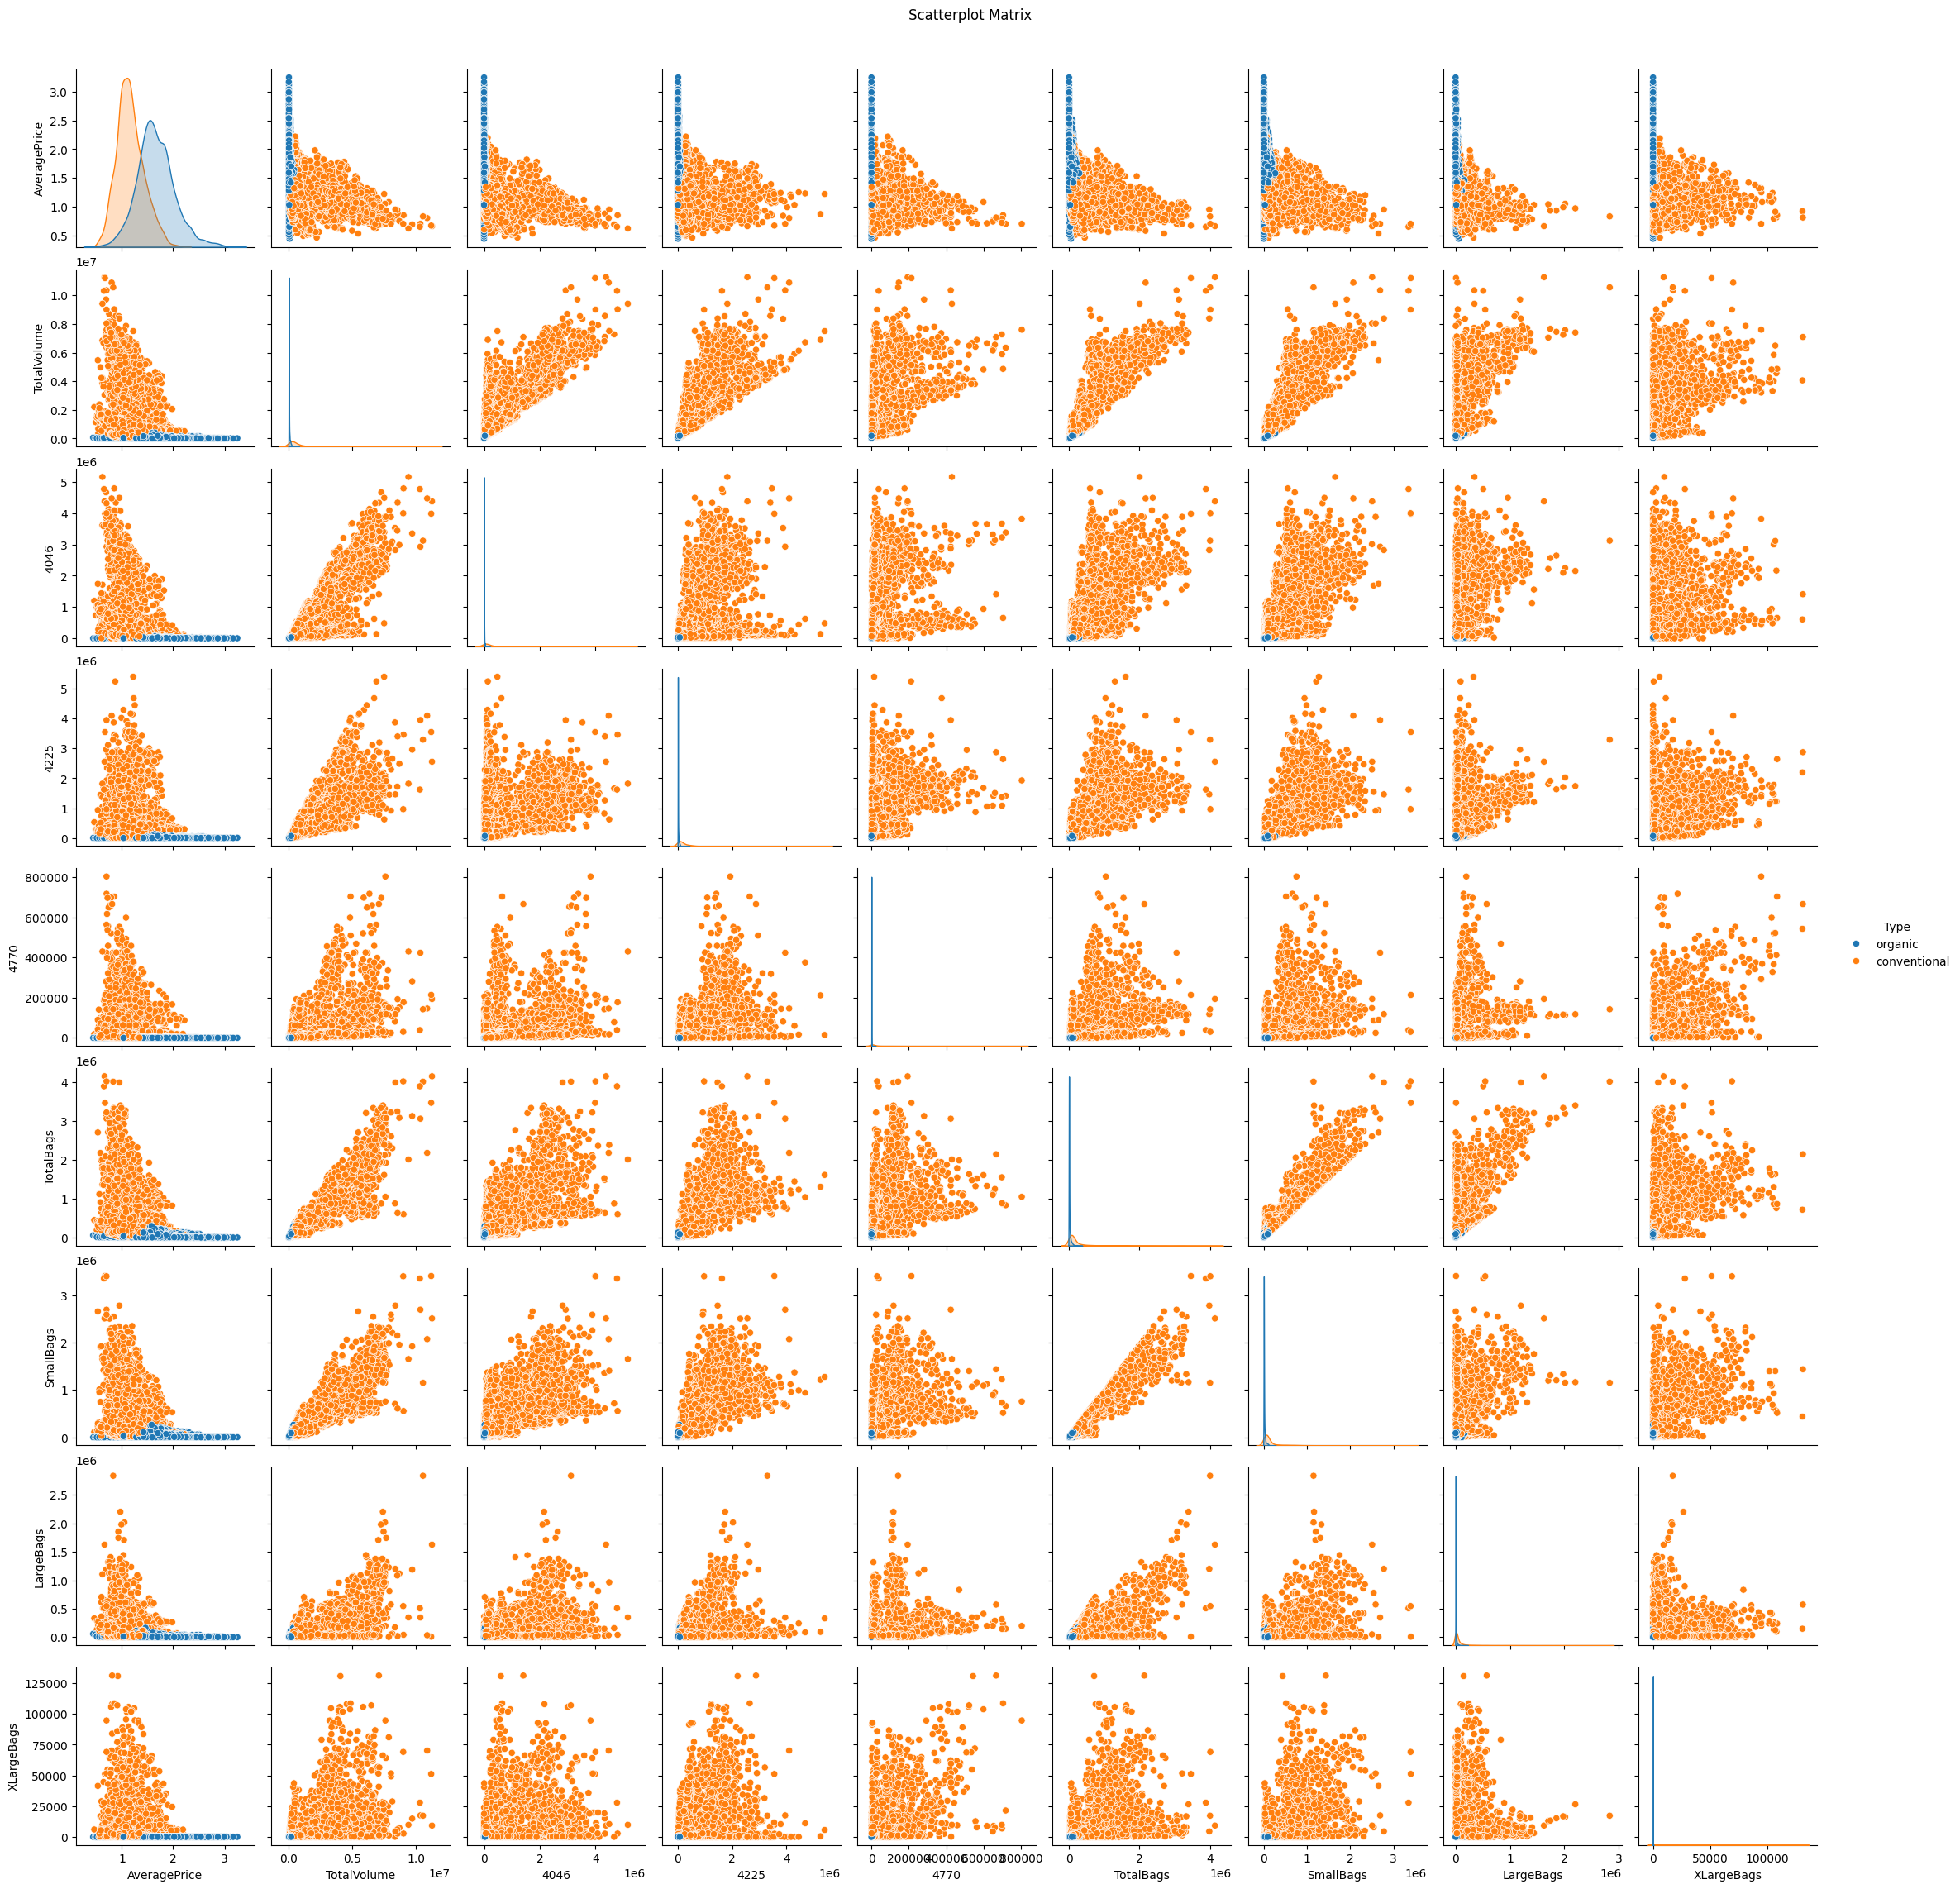

In [118]:
# There is some strange clustering in the data, 
# investigating further we get that the totalUS region is quite different since it's an aggregation
# Excluding it we get:

sns.pairplot(df[df['Region'] != 'TotalUS'], hue='Type')
plt.suptitle('Scatterplot Matrix', y=1.02)
plt.show()

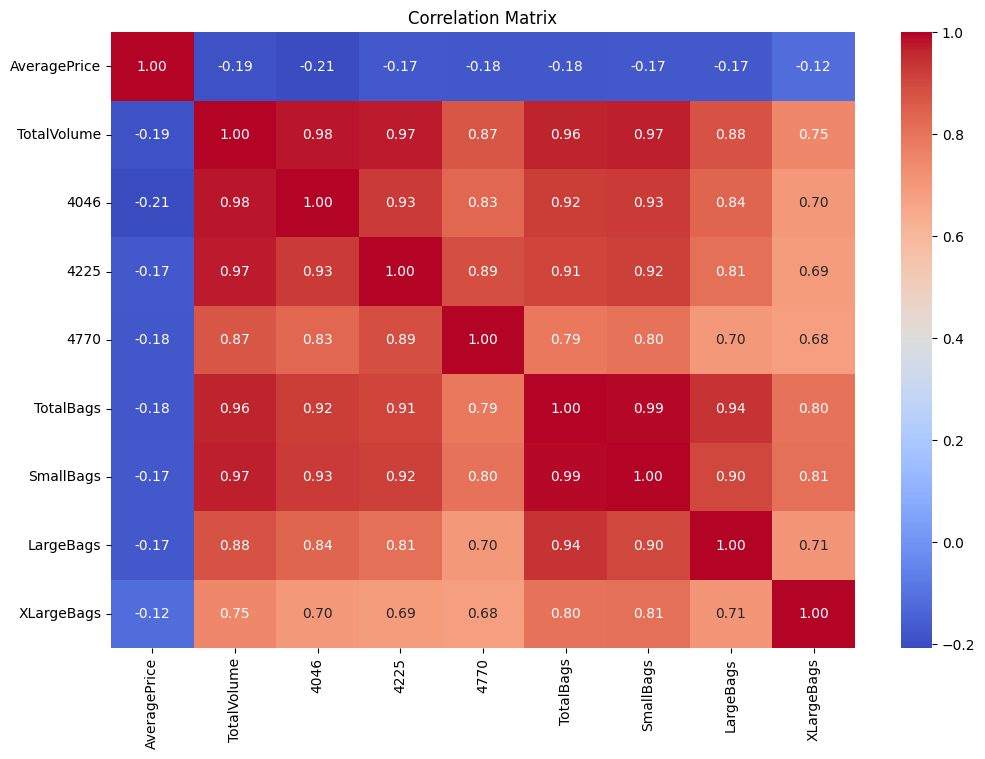

In [120]:
# Check correlations between numerical columns
correlation_matrix = df[numerical_columns].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

## Aggregations

Since i decided that i want to forecast the average avocado prices i need to aggregate the data that currently is separated by types.

In [20]:
# Receives a group and combines all the variables
def aggregate_types(group):
    total_volume = group['TotalVolume'].sum()
    weighted_avg = (group['AveragePrice'] * group['TotalVolume']).sum() / total_volume
    return pd.Series({
        'Date': group['Date'].iloc[0],
        'Region': group['Region'].iloc[0],
        'AveragePrice_combined': weighted_avg, # The average price is wighted against the total volumes
        'TotalVolume_combined': total_volume,
        '4046_combined': group['4046'].sum(),
        '4225_combined': group['4225'].sum(),
        '4770_combined': group['4770'].sum(),
        'TotalBags_combined': group['TotalBags'].sum(),
        'SmallBags_combined': group['SmallBags'].sum(),
        'LargeBags_combined': group['LargeBags'].sum(),
        'XLargeBags_combined': group['XLargeBags'].sum(),
    })

def group_by_region(df):
    combined_df = df.groupby(['Date', 'Region'])[df.columns].apply(aggregate_types).reset_index(drop=True)
    return combined_df

grouped_df = group_by_region(df)

Those are the differences for an example date and region

In [21]:
df[(df['Date'] == '2015-01-04') & (df['Region'] == 'Albany')]

Date  AveragePrice  TotalVolume     4046      4225  4770  \
9177 2015-01-04          1.79      1373.95    57.42    153.88   0.0   
51   2015-01-04          1.22     40873.28  2819.50  28287.42  49.9   

      TotalBags  SmallBags  LargeBags  XLargeBags          Type  Region  
9177    1162.65    1162.65       0.00         0.0       organic  Albany  
51      9716.46    9186.93     529.53         0.0  conventional  Albany

In [22]:
grouped_df[(grouped_df['Date'] == '2015-01-04') & (grouped_df['Region'] == 'Albany')]

Date  Region  AveragePrice_combined  TotalVolume_combined  \
0 2015-01-04  Albany               1.238537              42247.23   

   4046_combined  4225_combined  4770_combined  TotalBags_combined  \
0        2876.92        28441.3           49.9            10879.11   

   SmallBags_combined  LargeBags_combined  XLargeBags_combined  
0            10349.58              529.53                  0.0

## Pivoting

If i run the models in this aggregated data i loose the information about the dinamic between organic and conventional sales, so lets get this info back. For this I'll pivot the data and add the values as columns to my aggregated dataset

In [23]:
def pivot_and_merge_numerical_columns(df, grouped_df, target_name):
    numerical_columns = df.select_dtypes(include=['number']).columns
    # numerical_columns = numerical_columns.drop('AveragePrice')
    # Pivots arround date and region to separate each type value a column
    pivot_df = df.pivot(index=['Date','Region'], columns='Type', values=numerical_columns).reset_index()
    # Uses _ to join names
    pivot_df.columns = pivot_df.columns.map(lambda col: '_'.join(map(str, col)).strip('_'))
    # Merges data back toghether with the grouped DF
    merge_df = pd.merge(pivot_df, df[['Date', 'Type', 'Region']], on=['Date', 'Region'], how='left')
    merge_df = pd.merge(merge_df, grouped_df, on=['Date', 'Region'], how='left')
    # Since i pivoted the columns, now each row has the information of the AveragePrice 
    # for both organic and conventional, AND a type flag separating the entries. But since
    # I need a target for the forecast, another merge is done to get the price for the row's type
    merge_df = pd.merge(merge_df, df[['Region', 'Date', 'Type', target_name]], on=['Date', 'Region', 'Type'], how='left')
    return merge_df

target_name = 'AveragePrice'
merge_df = pivot_and_merge_numerical_columns(df, grouped_df, target_name)

In [24]:
merge_df[['Date', 'Region', 'Type' ,'AveragePrice_conventional', 'AveragePrice_organic', 'AveragePrice']].head()

Date               Region          Type  AveragePrice_conventional  \
0 2015-01-04               Albany       organic                       1.22   
1 2015-01-04               Albany  conventional                       1.22   
2 2015-01-04              Atlanta  conventional                       1.00   
3 2015-01-04              Atlanta       organic                       1.00   
4 2015-01-04  BaltimoreWashington       organic                       1.08   

   AveragePrice_organic  AveragePrice  
0                  1.79          1.79  
1                  1.79          1.22  
2                  1.76          1.00  
3                  1.76          1.76  
4                  1.29          1.29

I have now 2 entries for each date/region pair, one for organic an one for conventional, and those rows have information regarding the other. So i can use this to calculate lagged features in the future and since the grouping is done by date this does not leak future information for the observations

Combining everything in one function we get

In [25]:
def make_stage_1_data(configs):
    df = load_raw_data()
    df = preprocess_raw_data(df)
    grouped_df = group_by_region(df)
    merge_df = pivot_and_merge_numerical_columns(df, grouped_df, configs['target_name'])
    return merge_df

# Feature engineering

Now i need to make features to feed my regression model.

Since this is an exercise I'll be adding only lags and time related features. In a real world scenario more transformations can be applyied and tested to improve performance, such as seasonal decompositions, rolling statistics, cyclical features and etc...

I need a fuction to select one single region, since I'll be training a separate model for each

In [26]:
def select_region(merge_df, region):
    sel_df = merge_df[merge_df['Region'] == region].reset_index(drop=True)
    return sel_df.drop(columns='Region')

## Lags

This function will create lagged columns for a single region, with an option for adding the region name to the created column (will be usefull later)

In [27]:
def make_lags_single_column(sel_df, lags, lag_column, region_name=False):
    '''Create lag features for a single region and lag column.

    Parameters:
    sel_df (pd.DataFrame): The input DataFrame containing the data.
    lags (list): A list of integers representing the lag periods to create.
    lag_column (str): The name of the column for which to create lag features.
    region_name (str or bool, optional): The name of the region to include in the lag feature names. 
                                         If False, the region name is not included. Default is False.

    Returns:
    pd.DataFrame: A DataFrame containing the lag features.'''
    # TODO Raise error if sel_df has multiple regions
    lag_feats = pd.DataFrame(index=sel_df.index)
    for lag in lags:
        if region_name:
            lag_feats[f'{region_name}_{lag_column}_lag_{lag}'] = sel_df.groupby('Type')[lag_column].shift(lag)
        else:
            lag_feats[f'{lag_column}_lag_{lag}'] = sel_df.groupby('Type')[lag_column].shift(lag)
    return lag_feats

Here is a function that will serve to call the make_lags_single_column() function on desired columns, handling the logic for adding the col name as well.

In [28]:
def make_region_lags(region_filt_df, region_name, columns_to_lag, lags ,region_name_in_col = False):
    lag_features = []
    for col_name in columns_to_lag:
        if region_name_in_col:
            lag_features.append(make_lags_single_column(region_filt_df, lags, col_name, region_name))
        else:
            lag_features.append(make_lags_single_column(region_filt_df, lags, col_name))
    return pd.concat(lag_features, axis=1)

Now i need a way to make the lagged features for a specific region from the merged dataframe.

And while we are at it, could it be that the market behaviour in region A influences the prices in region B?

If we only calculate the lags from the target region, the models will loose this information. 

To account for this, I'll also calculate lags from a set of aggregated regions from the merged dataset and add them to my separate region models. Doing this i can feed the general market information to the models. 

Those "Exogenous" regions will be called aux_regions

To coordinate all those lagging and aux features operations I'll make a configs dictionary that will specify what needs to be done

In [ ]:
configs = {
        "target_name": "AveragePrice", # Name of the target variable to predict
        "lags":[4], # The lags to be calculated for all the columns of the selected target region
        "aux_regions": ['TotalUS'], # "Exogenous" (auxiliary) regions to be used as inputs when predicting the target region
        "aux_features": ['AveragePrice_combined', 'TotalVolume_combined', # Features of the aux regions to include
                         '4046_combined', '4225_combined', '4770_combined', 
                         'TotalBags_combined', 'SmallBags_combined', 
                         'LargeBags_combined', 'XLargeBags_combined'],
        "aux_lags": [4], # The lags of the aux features to be calculated
        'rolling_window_sizes': [12] #Size of windows in number of weeks
    }

Since the objective is to make a 4 weeks ahead forecast, the minimum lag I can use is 4. Less than that, the model would not work in the real world. 

Eg: if im in week 5 and using the second lag as a feature, my fourth week forecast would need information from week 7, which is in the future.

Now finally i can make the function that will receive the complete merged dataframe, the specified configs and return the lagged columns

In [30]:
def make_target_region_lags_df(merge_df, target_region, train_configs):
    # Lags for the target region
    region_filt_df = select_region(merge_df, target_region)
    columns_to_lag = merge_df.loc[:, merge_df.columns != train_configs['target_name']].select_dtypes(
        include=['number']).columns
    target_region_lags_df = make_region_lags(region_filt_df, target_region, columns_to_lag, train_configs['lags'])

    # Lags for Auxiliary regions
    aux_regions_lags = []
    for aux_region_name in train_configs['aux_regions']:
        if aux_region_name == target_region:
            continue
        
        aux_region_filt_df = select_region(merge_df, aux_region_name).reset_index()
        aux_regions_lags.append(
            make_region_lags(
                aux_region_filt_df, 
                aux_region_name, 
                train_configs['aux_features'], 
                train_configs['aux_lags'],
                region_name_in_col=True))
    aux_regions_lags_df = pd.concat(aux_regions_lags, axis=1)

    return pd.concat([target_region_lags_df, aux_regions_lags_df], axis=1)

Now i can get my lags with

In [31]:
region = 'Albany'
lags_df = make_target_region_lags_df(merge_df, region, configs)

In [32]:
lags_df

AveragePrice_conventional_lag_4  AveragePrice_organic_lag_4  \
0                                NaN                         NaN   
1                                NaN                         NaN   
2                                NaN                         NaN   
3                                NaN                         NaN   
4                                NaN                         NaN   
..                               ...                         ...   
333                             1.45                        1.43   
334                             1.43                        1.43   
335                             1.43                        1.43   
336                             1.28                        1.56   
337                             1.28                        1.56   

     TotalVolume_conventional_lag_4  TotalVolume_organic_lag_4  \
0                               NaN                        NaN   
1                               NaN                        NaN   
2                               NaN                        NaN   
3                               NaN                        NaN   
4                               NaN                        NaN   
..                              ...                        ...   
333                       121804.36                    3817.93   
334                        85630.24                    7566.17   
335                        85630.24                    7566.17   
336                       104278.89                    5356.63   
337                       104278.89                    5356.63   

     4046_conventional_lag_4  4046_organic_lag_4  4225_conventional_lag_4  \
0                        NaN                 NaN                      NaN   
1                        NaN                 NaN                      NaN   
2                        NaN                 NaN                      NaN   
3                        NaN                 NaN                      NaN   
4                        NaN                 NaN                      NaN   
..                       ...                 ...                      ...   
333                  8183.48               59.18                 95548.47   
334                  5499.73             4314.30                 61661.76   
335                  5499.73             4314.30                 61661.76   
336                 10368.77              816.56                 59723.32   
337                 10368.77              816.56                 59723.32   

     4225_organic_lag_4  4770_conventional_lag_4  4770_organic_lag_4  ...  \
0                   NaN                      NaN                 NaN  ...   
1                   NaN                      NaN                 NaN  ...   
2                   NaN                      NaN                 NaN  ...   
3                   NaN                      NaN                 NaN  ...   
4                   NaN                      NaN                 NaN  ...   
..                  ...                      ...                 ...  ...   
333              289.85                     61.0                 0.0  ...   
334              251.85                     75.0                 0.0  ...   
335              251.85                     75.0                 0.0  ...   
336              532.59                     48.0                 0.0  ...   
337              532.59                     48.0                 0.0  ...   

     XLargeBags_combined_lag_4  TotalUS_AveragePrice_combined_lag_4  \
0                          NaN                                  NaN   
1                          NaN                                  NaN   
2                          NaN                                  NaN   
3                          NaN                                  NaN   
4                          NaN                                  NaN   
..                         ...                                  ...   
333                     451.11                  

In [33]:
lags_df.columns

Index(['AveragePrice_conventional_lag_4', 'AveragePrice_organic_lag_4',
       'TotalVolume_conventional_lag_4', 'TotalVolume_organic_lag_4',
       '4046_conventional_lag_4', '4046_organic_lag_4',
       '4225_conventional_lag_4', '4225_organic_lag_4',
       '4770_conventional_lag_4', '4770_organic_lag_4',
       'TotalBags_conventional_lag_4', 'TotalBags_organic_lag_4',
       'SmallBags_conventional_lag_4', 'SmallBags_organic_lag_4',
       'LargeBags_conventional_lag_4', 'LargeBags_organic_lag_4',
       'XLargeBags_conventional_lag_4', 'XLargeBags_organic_lag_4',
       'AveragePrice_combined_lag_4', 'TotalVolume_combined_lag_4',
       '4046_combined_lag_4', '4225_combined_lag_4', '4770_combined_lag_4',
       'TotalBags_combined_lag_4', 'SmallBags_combined_lag_4',
       'LargeBags_combined_lag_4', 'XLargeBags_combined_lag_4',
       'TotalUS_AveragePrice_combined_lag_4',
       'TotalUS_TotalVolume_combined_lag_4', 'TotalUS_4046_combined_lag_4',
       'TotalUS_4225_combined_l

## One hot encodes and time features

Add back date, type and target info

In [34]:
region_filt_df = select_region(merge_df, region)
feat_df = pd.concat([
    region_filt_df[['Date', 'Type', configs['target_name']]], 
    lags_df], axis=1)

Regression models need those, so lets add them. Will do cyclical features instead of simple ones

In [ ]:
def make_time_features(sel_df):
    time_feats = pd.DataFrame(index=sel_df.index)
    dates = sel_df['Date']
    time_feats['Year'] = dates.dt.year
    time_feats['MonthSin'] = np.sin(2 * np.pi * dates.dt.month/ 12)
    time_feats['MonthCos'] = np.cos(2 * np.pi * dates.dt.month/ 12)
    time_feats['Day'] = dates.dt.day
    time_feats['DayofWeekSin'] = np.sin(2 * np.pi * dates.dt.dayofweek/ 7)
    time_feats['DayofWeekCos'] = np.cos(2 * np.pi * dates.dt.dayofweek/ 7)
    time_feats["WeekofYearSin"] = np.sin(2 * np.pi * dates.dt.isocalendar().week / 52)
    time_feats["WeekofYearCos"] = np.cos(2 * np.pi * dates.dt.isocalendar().week / 52)
    time_feats["QuarterSin"] = np.sin(2 * np.pi * dates.dt.quarter / 4)
    time_feats["QuarterCos"] = np.cos(2 * np.pi * dates.dt.quarter / 4)
    time_feats['TimeIndex'] = ((dates - dates.min()).dt.days) // 7  # A simple trend feature

    return time_feats


feat_df = pd.concat([feat_df, make_time_features(feat_df)], axis=1)

Calculate rolling statistics from the lags to avoid data leak

In [ ]:
def make_rolling(feat_df, window_sizes):
    for size in window_sizes:
        feat_df[f'rolling_{size}_mean'] = feat_df.groupby('Type')['AveragePrice_combined_lag_4'].transform(
            lambda x: x.rolling(size).mean())
        feat_df[f'rolling_{size}_mean'] = feat_df.groupby('Type')['AveragePrice_combined_lag_4'].transform(
            lambda x: x.rolling(size).std())
        feat_df[f'rolling_{size}_mean'] = feat_df.groupby('Type')['AveragePrice_combined_lag_4'].transform(
            lambda x: x.rolling(size).max())
        feat_df[f'rolling_{size}_mean'] = feat_df.groupby('Type')['AveragePrice_combined_lag_4'].transform(
            lambda x: x.rolling(size).min())
    return feat_df

feat_df = make_rolling(feat_df, configs['rolling_window_sizes'])

One hot encode type

In [36]:
feat_df = pd.get_dummies(feat_df, columns=['Type'], prefix='Type')

Since we are concatenating, with different regions, there is a chance some dates are present in one but not the other, so just dropping the nulls solves it. (In the real world more appropriate data quality checks can be implemented in a prior data engineering stage)

In [37]:
feat_df = feat_df.loc[~feat_df['Date'].isnull(), :]
dates = feat_df['Date'] # also store the dates not to loose the info (usefull for plotting)
feat_df = feat_df.drop(columns='Date')

Finally, now I'll make the model ready data

In [38]:
X = feat_df[feat_df.columns.difference([configs['target_name']])]
y = feat_df[configs['target_name']]

In [39]:
X

4046_combined_lag_4  4046_conventional_lag_4  4046_organic_lag_4  \
0                    NaN                      NaN                 NaN   
1                    NaN                      NaN                 NaN   
2                    NaN                      NaN                 NaN   
3                    NaN                      NaN                 NaN   
4                    NaN                      NaN                 NaN   
..                   ...                      ...                 ...   
333              8242.66                  8183.48               59.18   
334              9814.03                  5499.73             4314.30   
335              9814.03                  5499.73             4314.30   
336             11185.33                 10368.77              816.56   
337             11185.33                 10368.77              816.56   

     4225_combined_lag_4  4225_conventional_lag_4  4225_organic_lag_4  \
0                    NaN                      NaN                 NaN   
1                    NaN                      NaN                 NaN   
2                    NaN                      NaN                 NaN   
3                    NaN                      NaN                 NaN   
4                    NaN                      NaN                 NaN   
..                   ...                      ...                 ...   
333             95838.32                 95548.47              289.85   
334             61913.61                 61661.76              251.85   
335             61913.61                 61661.76              251.85   
336             60255.91                 59723.32              532.59   
337             60255.91                 59723.32              532.59   

     4770_combined_lag_4  4770_conventional_lag_4  4770_organic_lag_4  \
0                    NaN                      NaN                 NaN   
1                    NaN                      NaN                 NaN   
2                    NaN                      NaN                 NaN   
3                    NaN                      NaN                 NaN   
4                    NaN                      NaN                 NaN   
..                   ...                      ...                 ...   
333                 61.0                     61.0                 0.0   
334                 75.0                     75.0                 0.0   
335                 75.0                     75.0                 0.0   
336                 48.0                     48.0                 0.0   
337                 48.0                     48.0                 0.0   

     AveragePrice_combined_lag_4  ...  TotalVolume_combined_lag_4  \
0                            NaN  ...                         NaN   
1                            NaN  ...                         NaN   
2                            NaN  ...                         NaN   
3                            NaN  ...                         NaN   
4                            NaN  ...                         NaN   
..                           ...  ...                         ...   
333                     1.449392  ...                   125622.29   
334                     1.430000  ...                    93196.41   
335                     1.430000  ...                    93196.41   
336                     1.293680  ...                   109635.52   
337                     1.293680  ...                   109635.52   

     TotalVolume_conventional_lag_4  TotalVolume_organic_lag_4  \
0                               NaN                        NaN   
1                               NaN                        NaN   
2                               NaN                        NaN   
3                               NaN                        NaN   
4                               NaN                        NaN   
..                              ...                        ...   
333                       121804.36                    3817.93   
334              

In [40]:
X.columns

Index(['4046_combined_lag_4', '4046_conventional_lag_4', '4046_organic_lag_4',
       '4225_combined_lag_4', '4225_conventional_lag_4', '4225_organic_lag_4',
       '4770_combined_lag_4', '4770_conventional_lag_4', '4770_organic_lag_4',
       'AveragePrice_combined_lag_4', 'AveragePrice_conventional_lag_4',
       'AveragePrice_organic_lag_4', 'Day', 'DayofWeek',
       'LargeBags_combined_lag_4', 'LargeBags_conventional_lag_4',
       'LargeBags_organic_lag_4', 'Month', 'Quarter',
       'SmallBags_combined_lag_4', 'SmallBags_conventional_lag_4',
       'SmallBags_organic_lag_4', 'TotalBags_combined_lag_4',
       'TotalBags_conventional_lag_4', 'TotalBags_organic_lag_4',
       'TotalUS_4046_combined_lag_4', 'TotalUS_4225_combined_lag_4',
       'TotalUS_4770_combined_lag_4', 'TotalUS_AveragePrice_combined_lag_4',
       'TotalUS_LargeBags_combined_lag_4', 'TotalUS_SmallBags_combined_lag_4',
       'TotalUS_TotalBags_combined_lag_4',
       'TotalUS_TotalVolume_combined_lag_4',
    

In [41]:
y

0      1.79
1      1.22
2      1.77
3      1.24
4      1.17
       ... 
333    1.68
334    1.66
335    1.35
336    1.57
337    1.71
Name: AveragePrice, Length: 338, dtype: float64

Combining all the feat eng in one function we get

In [ ]:
def make_stage_2_data(merge_df, region, train_configs):
    lags_df = make_target_region_lags_df(merge_df, region, train_configs)
    region_filt_df = select_region(merge_df, region)
    feat_df = pd.concat([
        region_filt_df[['Date', 'Type', train_configs['target_name']]], 
        lags_df], axis=1)

    feat_df = pd.concat([feat_df, make_time_features(feat_df)], axis=1)
    feat_df = make_rolling(feat_df, configs['rolling_window_sizes'])
    feat_df = pd.get_dummies(feat_df, columns=['Type'], prefix='Type')

    feat_df = feat_df.loc[~feat_df['Date'].isnull(), :]
    dates = feat_df['Date']
    feat_df = feat_df.drop(columns='Date')
    
    X = feat_df[feat_df.columns.difference([train_configs['target_name']])]
    y = feat_df[train_configs['target_name']]
    
    return X, y, dates

# Modelling and validation

## Hyperparameter optimization

Before the main train loop i made a grid search with optuna to optimize the models. The scores and parameters were logged to MLflow

To specify which regions to iterate I'll add a key "target_regions" to the configs like this

In [43]:
# configs = {
#         "target_name": "AveragePrice", # Name of the target variable to predict
#         "lags":[4, 8, 13, 26, 52],
#         'target_regions': merge_df['Region'].unique(),
#         "aux_regions": ['TotalUS', 'West', 'Midsouth', 'Northeast', 'Southeast', 'SouthCentral'], # "Exogenous" (auxiliary) regions to be used as inputs when predicting the target region
#         "aux_features": ['AveragePrice_combined', 'TotalVolume_combined', # Features of the aux regions to include
#                          '4046_combined', '4225_combined', '4770_combined', 
#                          'TotalBags_combined', 'SmallBags_combined', 
#                          'LargeBags_combined', 'XLargeBags_combined'],
#         "aux_lags": [4, 8, 13, 26, 52],
#     }

This was the code executed to get the best parameters for each region, but since it would take too long to run it here, ill be skipping it. A JSON file with my results is included in the repo.

In [ ]:
# import mlflow
# import mlflow.xgboost
# import xgboost as xgb
# from sklearn.model_selection import TimeSeriesSplit, train_test_split
# from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
# import numpy as np
# import pandas as pd
# import os
# import optuna
# import feature_eng
# import json

# # Set your MLflow experiment name
# mlflow.set_experiment("Optuna Hyperparameter Optimization")

# # Define the objective function for Optuna
# def objective(trial):
#     params = {
#         "n_estimators": trial.suggest_int("n_estimators", 50, 200),
#         "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2),
#         "max_depth": trial.suggest_int("max_depth", 3, 7),
#         "subsample": trial.suggest_float("subsample", 0.5, 1.0),
#         "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
#         "gamma": trial.suggest_float("gamma", 0, 5),
#         "reg_alpha": trial.suggest_float("reg_alpha", 0, 5),
#         "reg_lambda": trial.suggest_float("reg_lambda", 0, 5)
#     }
    
#     fold_mse = []
#     fold_mape = []
    
#     for fold, (train_cv_index, val_cv_index) in enumerate(tscv.split(X_train)):
#         X_train_cv, X_val_cv = X_train.iloc[train_cv_index], X_train.iloc[val_cv_index]
#         y_train_cv, y_val_cv = y_train.iloc[train_cv_index], y_train.iloc[val_cv_index]
        
#         model = xgb.XGBRegressor(**params)
#         model.fit(X_train_cv, y_train_cv)
        
#         # Make predictions and compute performance
#         y_pred_cv = model.predict(X_val_cv)
#         mse = mean_squared_error(y_val_cv, y_pred_cv)
#         mape = mean_absolute_percentage_error(y_val_cv, y_pred_cv)
#         fold_mse.append(mse)
#         fold_mape.append(mape)
    
#     avg_mse = np.mean(fold_mse)   
#     avg_mape = np.mean(fold_mape)    
    
#     return avg_mape

# for region in configs['target_regions']:
#     print(f'Training: {region}')
#     X, y, dates = feature_eng.make_stage_2_data(merge_df, region, configs)

#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    
#     # Start one run per region
#     with mlflow.start_run(run_name=f"Region: {region}") as region_run:
#         mlflow.log_param("region", region)
        
#         # Expanding window CV.
#         tscv = TimeSeriesSplit(n_splits=5)
        
#         # Perform hyperparameter optimization with Optuna
#         study = optuna.create_study(direction="minimize")
#         study.optimize(objective, n_trials=40)
        
#         # Log the best parameters
#         best_params = study.best_params
#         mlflow.log_params(best_params)
        
#         # Log the best cross-validation scores
#         best_mape = study.best_value
#         mlflow.log_metric("best_cv_mape", best_mape)


# experiment_name = "Optuna Hyperparameter Optimization"
# runs = mlflow.search_runs(experiment_names=['Optuna Hyperparameter Optimization'])
# region_params_dict = {}

# # Loop over each run to get parameters
# for index, run in runs.iterrows():
#     region = run['params.region']
#     params_dict = {param_name.split('params.')[1]: param_value for param_name, param_value in run.items() if param_name.startswith('params.')}
#     params_dict.pop('region')
#     region_params_dict[region] = params_dict

# # Save to JSON file
# json_path = "region_best_params.json"
# with open(json_path, 'w') as json_file:
#     json.dump(region_params_dict, json_file, indent=4)

# print(f"Dictionary saved to {json_path}")

## Main train loop

The model is trained on the entire train set using the best cross validated parameters for each region. After that there is another retraining, this time with the entire dataset, the retrained model is then logged and registered to an MLflow server to be later fetched for the deploy.

Lets define a smaller set of target regions so it would not take long

In [ ]:
configs = {
        "target_name": "AveragePrice", # Name of the target variable to predict
        "lags":[4], # The lags to be calculated for all the columns of the selected target region
        'target_regions':['Chicago', 'Albany'], # The regions i want to forecast
        "aux_regions": ['TotalUS', 'West', 'Midsouth', 'Northeast', 'Southeast', 'SouthCentral'], # "Exogenous" (auxiliary) regions to be used as inputs when predicting the target region
        "aux_features": ['AveragePrice_combined', 'TotalVolume_combined', # Features of the aux regions to include
                         '4046_combined', '4225_combined', '4770_combined', 
                         'TotalBags_combined', 'SmallBags_combined', 
                         'LargeBags_combined', 'XLargeBags_combined'],
        "aux_lags": [4], # The lags to be calculated of the aux features
        'rolling_window_sizes': [12]

    }

In [113]:
import json
import warnings
def convert_numbers(obj):
        for key, value in obj.items():
            if isinstance(value, str) and value.isdigit():
                obj[key] = int(value)
            elif isinstance(value, str):
                try:
                    obj[key] = float(value)
                except ValueError:
                    pass
        return obj

def load_best_params(region, from_json=True):
    if from_json:
        with open('modelling/region_best_params.json') as file:
            best_params = json.load(file, object_hook=convert_numbers)
        if region in best_params:
            return best_params[region]
        else:
            warnings.warn(f"No best parameters found for region: {region}, returning empty defaults")
            return {}
    
    return

For visualizing results easily I'll make a plotting function

In [47]:
def plot_results(y_train, y_true, y_pred, target_name, dates, fold=None):
    # Plot the fold results
    plt.figure(figsize=(12, 6))
    plt.plot(dates.loc[y_train.index], y_train, label='Train')
    plt.plot(dates.loc[y_true.index], y_true, label='True')
    plt.plot(dates.loc[y_true.index], y_pred, label='Predicted')
    plt.legend()
    if fold:
        plt.title(f"Train, Validation, and Predicted Values - Fold {fold}")
    else:
        plt.title(f"Train, Test, and Predicted Values")
    plt.xlabel("Date")
    plt.ylabel(target_name)
    return plt


Now, the main train loop. To not interfere with the actual model registry I'll leave it commented

In [48]:
# import dotenv

# dotenv.load_dotenv()

# mlflow.set_tracking_uri("http://localhost:5000")

# mlflow.set_experiment("Example Experiment")

# for region in configs['target_regions']:
#     print(f'Trainning: {region}')
#     X, y, dates = make_stage_2_data(merge_df, region, configs)
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    
#     # Start one run per region
#     with mlflow.start_run(run_name=f"Region: {region}") as region_run:
#         mlflow.log_param("region", region)

#         # get best params from grid search
#         params = load_best_params(region, from_json=True)

#         # Evaluate final model on the hold-out test set using training data only
#         final_model_cv = xgb.XGBRegressor(**params)
#         final_model_cv.fit(X_train, y_train)
#         y_test_pred = final_model_cv.predict(X_test)
#         test_mse = mean_squared_error(y_test, y_test_pred)
#         mlflow.log_metric("test_mse", test_mse)
        
#         plot = plot_results(y_train, y_test, y_test_pred, configs['target_name'], dates)
#         plot_path = f"plot_test.png"
#         plot.savefig(plot_path)
#         mlflow.log_artifact(plot_path)
#         plot.close()
#         # Delete the plot file after logging it
#         if os.path.exists(plot_path):
#             os.remove(plot_path)
        
#         final_model = xgb.XGBRegressor(**params)
#         final_model.fit(X, y)

#         mlflow.xgboost.log_model(final_model, artifact_path="final_model", input_example=X.iloc[:1])
        
#         # Skipping this so to not interfere with the model registry beeing used by the API
#         # # Register the model
#         # model_uri = mlflow.get_artifact_uri("final_model")
#         # mlflow.register_model(model_uri, name=f'{region}_AVOCADO_FORECAST_EXAMPLE')

The models can now be analyzed inside MLFlow and deployed for serving predictions with a restAPI that loads them from the MLFlow model registry

# API testing

Run this cells only after starting the API (instructions on the readme file).

This refreshes the loaded models to fetch the most recent versions

In [103]:
import requests
url = 'http://localhost:8000/reload-models'
# Make a prediction request to the API
response = requests.post(url)
# Print the results
print("Status Code:", response.status_code)
print("Response JSON:", response.json())

Status Code: 200
Response JSON: {'message': 'Models reloaded successfully'}


In [106]:
# load the configs used for the training
import modelling
import modelling.data_processing
import modelling.feature_eng
region = 'Atlanta'

merge_df = modelling.data_processing.make_stage_1_data(modelling.configs.configs)
X, y, dates = modelling.feature_eng.make_stage_2_data(merge_df, region, modelling.configs.configs)

In [108]:
merge_df

Date               Region  AveragePrice_conventional  \
0     2015-01-04               Albany                       1.22   
1     2015-01-04               Albany                       1.22   
2     2015-01-04              Atlanta                       1.00   
3     2015-01-04              Atlanta                       1.00   
4     2015-01-04  BaltimoreWashington                       1.08   
...          ...                  ...                        ...   
18244 2018-03-25              TotalUS                       1.03   
18245 2018-03-25                 West                       0.93   
18246 2018-03-25                 West                       0.93   
18247 2018-03-25     WestTexNewMexico                       0.84   
18248 2018-03-25     WestTexNewMexico                       0.84   

       AveragePrice_organic  TotalVolume_conventional  TotalVolume_organic  \
0                      1.79                  40873.28              1373.95   
1                      1.79                  40873.28              1373.95   
2                      1.76                 435021.49              3846.69   
3                      1.76                 435021.49              3846.69   
4                      1.29                 788025.06             19137.28   
...                     ...                       ...                  ...   
18244                  1.55               43409835.75           1559967.20   
18245                  1.60                7667064.46            271723.08   
18246                  1.60                7667064.46            271723.08   
18247                  1.62                 965185.06             15303.40   
18248                  1.62                 965185.06             15303.40   

       4046_conventional  4046_organic  4225_conventional  4225_organic  ...  \
0                2819.50         57.42           28287.42        153.88  ...   
1                2819.50         57.42           28287.42        153.88  ...   
2              364302.39       1500.15           23821.16        938.35  ...   
3              364302.39       1500.15           23821.16        938.35  ...   
4               53987.31       8040.64          552906.04       6557.47  ...   
...                  ...           ...                ...           ...  ...   
18244        14130799.10     121007.94        12125711.42     342853.10  ...   
18245         2567279.74      26996.28         1912986.38      77861.39  ...   
18246         2567279.74      26996.28         1912986.38      77861.39  ...   
18247          438526.12       2325.30          199585.90       2171.66  ...   
18248          438526.12       2325.30          199585.90       2171.66  ...   

       AveragePrice_combined  TotalVolume_combined  4046_combined  \
0                   1.238537              42247.23        2876.92   
1                   1.238537              42247.23        2876.92   
2                   1.006661             438868.18      365802.54   
3                   1.006661             438868.18      365802.54   
4                   1.084979             807162.34       62027.95   
...                      ...                   ...            ...   
18244               1.048038           44969802.95    14251807.04   
18245               0.952932            7938787.54     2594276.02   
18246               0.952932            7938787.54     2594276.02   
18247               0.852174             980488.46      440851.42   
18248               0.852174             980488.46      440851.42   

       4225_combined  4770_combined  TotalBags_combined  SmallBags_combined  \
0           28441.30          49.90            10879.11            10349.58   
1           28441.30          49.90            10879.11            10349.58   
2           24759.51          82.15            48223.98            17778.50   
3           24759.51          82.15            48223.98            17778.50   
4          559463.51       40652.51           145018.37           141027.

Now Lets try running the predictions for a region

In [107]:
url = f"http://localhost:8000/predict/{region}"

# Prepare the payload based on the required inputs
payload_df = X.copy()
payload_df = payload_df.iloc[-4:]
payload = payload_df.to_dict(orient='records')

# Make a prediction request to the API
response = requests.post(url, json=payload)

# Print the results
print("Status Code:", response.status_code)
print("Response JSON:", response.json())

Status Code: 200
Response JSON: {'region': 'Atlanta', 'prediction': [1.374897837638855, 1.0244910717010498, 1.4767241477966309, 1.0499247312545776]}


If we change the value in one of the columns for a non numeric where the model expects numerics, we get an input validation error

In [ ]:
url = f"http://localhost:8000/predict/{region}"

# Prepare the payload based on the required inputs
payload_df = X.copy()
payload_df = payload_df.iloc[-4:]
payload_df.iloc[0, 0] = 'BATATA'
payload = payload_df.to_dict(orient='records')

# Make a prediction request to the API
response = requests.post(url, json=payload)

# Print the results
print("Status Code:", response.status_code)
print("Response JSON:", response.json())

Status Code: 400
Response JSON: {'detail': "Invalid data: 1 validation error for schema_Atlanta_AVOCADO_FORECAST\n4046_combined_lag_13\n  Input should be a valid number, unable to parse string as a number [type=float_parsing, input_value='BATATA', input_type=str]\n    For further information visit https://errors.pydantic.dev/2.10/v/float_parsing"}


/tmp/ipykernel_63431/3511863882.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'BATATA' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  payload_df.iloc[:, 0] = 'BATATA'


We also get an error if trying to predict a non registered region

In [ ]:
region = 'SaoPaulo'
url = f"http://localhost:8000/predict/{region}"

# Prepare the payload based on the required inputs
payload_df = X.copy()
payload_df = payload_df.iloc[-4:]
payload = payload_df.to_dict(orient='records')

# Make a prediction request to the API
response = requests.post(url, json=payload)

# Print the results
print("Status Code:", response.status_code)
print("Response JSON:", response.json())

Status Code: 400
Response JSON: {'detail': "Schema for region 'SaoPaulo' not found"}
